## opg_t01_base_0519_npd1
基于 opg_aftertraining0519.ipynb
本代码主要完成ninapro db1 其他subject 的验证工作。

In [1]:
# -*- coding:utf-8 -*-
import datetime
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchviz import make_dot
# import hiddenlayer as h
from visdom import Visdom

# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

sys.path.append("..")
from utils.networks import *
from utils.reuse import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 预备操作
设置检查点、visdom 日志文件存储等日志性文件存储位置；
初始化 visdom,记得先在命令行输入 visdom 运行（python环境下）

In [2]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
# 现在model_Dir 作为所有文件的父目录，不再分设开导致文件难寻
model_Dir = "..//model//opg_testops_220611a//"
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)
# 这是正常定期检查点存储位置
ckpDir = model_Dir + "ckp//"
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)
# 这里是特挑最佳AUC的位置
ckpDir_auc = ckpDir + "auc//"
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)
# 这是 visdom 日志文件存储位置，留待备用
vislogDir = model_Dir + "vislog//"
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)

def get_current_time():
    return datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")


print(get_current_time())

timeForSave = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

2022_06_18_22_58_26


In [3]:
# 以下是 visdom 监视窗口初始化，实现每次启用时重新加载，这里只写了 NameError 以防其他错误不能被发现
class visdom_account:
    def __init__(self):
        self.port = 8097
        self.server = "http://localhost"
        self.base_url = "/"
        self.username = "admin"
        self.passward = "1234"
        self.evns = "train"


viz_acnt = visdom_account()


def viz_init():
    try:
        viz
    except NameError:
        viz = Visdom(
            env=viz_acnt.evns, log_to_filename=vislogDir + "vislog_" + timeForSave
        )
        print("visdom has started")
    else:
        viz.close()
        del viz
        print("last visdom session closed")
        viz = Visdom(
            env=viz_acnt.evns, log_to_filename=vislogDir + "vislog_" + timeForSave
        )
        print("visdom has restarted")
    return viz


viz = viz_init()

Setting up a new session...


visdom has started


## 定义CNN神经网络结构
CNN 训练部分，为了获得一个已知类分类器

In [4]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=0
        )

        self.fc1 = nn.Linear(in_features=32 * 10 * 20, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=10)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 32 * 10 * 20)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t


net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
summary(net, (1, 20, 10), batch_size=1, device="cpu")
# 可视化结构，torchviz
sampleInput = torch.randn(1, 1, 20, 10).requires_grad_(True)
sampleOutput = net(sampleInput)
print("Outputshape:", sampleOutput.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 20, 10]             320
            Conv2d-2            [1, 32, 20, 10]           9,248
            Linear-3                   [1, 128]         819,328
         Dropout2d-4                   [1, 128]               0
            Linear-5                    [1, 10]           1,290
Total params: 830,186
Trainable params: 830,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 3.17
Estimated Total Size (MB): 3.27
----------------------------------------------------------------
Outputshape: torch.Size([1, 10])


## 数据集加载、构建

In [5]:
# CNN训练数据加载
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
])

class EMGDataset(Dataset):
 
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.transforms = transform
 
    def __getitem__(self, index):
        emgData = self.data[index,:,:,:]
        emgData = np.squeeze(emgData)
        emglabel = self.label[index]
        emglabel = emglabel.astype(np.int16)
        emgData = self.transforms(emgData)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return emgData,emglabel
 
    def __len__(self):
        return len(self.label)
 
 
# if __name__ == '__main__':
dataarray = np.load('../../data/nina_db1/Fopgs2_multiset_20220611T161411.npy',allow_pickle=True)
CNNdataset = dataarray.item()
print(type(CNNdataset))
traindata = CNNdataset['ktr_X']
trainlabel = CNNdataset['ktr_Y']
testdata = CNNdataset['kte_X']
testlabel = CNNdataset['kte_Y']
# 先用5类的
valdata = CNNdataset['val_X_5c']
vallabel = CNNdataset['val_Y_5c']

trainlabel = trainlabel[:,0]
testlabel = testlabel[:,0]
vallabel = vallabel[:,0]
# trainunknownc_label = trainunknownc_label[:,0]
# print(type(trainlabel))
train_set = EMGDataset(traindata, trainlabel)
test_set = EMGDataset(testdata, testlabel)
val_set = EMGDataset(valdata, vallabel)
# train_unknown = EMGDataset(trainunknown_data,trainunknownc_label)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, pin_memory=True,
#                                             num_workers=3)

# 试运行数据集，构建迭代器
sample = iter(test_set)
print(sample)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=False)
batch1 = iter(train_loader)

<class 'dict'>


In [7]:
batch2 = next(batch1)
d_x,d_y = batch2
print(
    "x:",
    d_x.shape,
    d_x,
    "\n",
    "y:",
    d_y.shape,
    d_y
)

x: torch.Size([2, 1, 20, 10]) tensor([[[[0.2930, 0.3223, 0.0562, 0.0903, 0.0024, 0.0024, 0.0024, 0.1147,
           0.0464, 0.0049],
          [0.3101, 0.3027, 0.0854, 0.0757, 0.0024, 0.0024, 0.0024, 0.1270,
           0.0830, 0.0024],
          [0.3540, 0.3296, 0.1270, 0.0684, 0.0024, 0.0024, 0.0024, 0.1367,
           0.1294, 0.0024],
          [0.3760, 0.3809, 0.1416, 0.0659, 0.0024, 0.0024, 0.0024, 0.1416,
           0.1660, 0.0024],
          [0.3882, 0.4443, 0.1489, 0.0610, 0.0024, 0.0024, 0.0024, 0.1416,
           0.1807, 0.0024],
          [0.3882, 0.4932, 0.2368, 0.0830, 0.0024, 0.0024, 0.0024, 0.1758,
           0.1953, 0.0049],
          [0.3809, 0.5029, 0.4102, 0.1050, 0.0049, 0.0049, 0.0073, 0.2246,
           0.2173, 0.0024],
          [0.3662, 0.4761, 0.4834, 0.1099, 0.0024, 0.0024, 0.0098, 0.2612,
           0.2222, 0.0049],
          [0.3418, 0.4297, 0.4810, 0.1343, 0.0049, 0.0024, 0.0073, 0.2661,
           0.2148, 0.0073],
          [0.3271, 0.4272, 0.4517, 0.1563, 

In [6]:
# CNN 训练
# 损失
# criterion = nn.BCEWithLogitsLoss().to(device)
# 加载数据，设置优化器
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5, last_epoch=-1)
# 初始化 visdom
viz.close()
viz = viz_init()
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
viz = Visdom(
    env=viz_acnt.evns, log_to_filename=vislogDir + "vislog_" + get_current_time()
)
vizx = 0
viz.text(
    "MONITOR: Show train process~~",
    win="Monitor",
    opts={
        "title": "ProcessMonitor",
    },
)

total_test_acc = 0
total_test_correct = 0
totaltest = 0
# 训练过程
epoch_num = 600
net.to(device)
for epoch in range(epoch_num):
    viz.text(
        "ep" + str(epoch + 1) + " start",
        win="Monitor",
        opts={
            "title": "ProcessMonitor",
        },
    )
    total_loss = 0
    total_correct = 0
    curr_total_correct = 0
    total_traintnum = 0
    for batch in train_loader:
        # 载入本批次数据
        batch = batch
        images, labels = batch
        images = images.to(torch.float32).to(device)
        labels = labels.long().to(device)
        net.train()
        preds = net(images)
        trainloss = F.cross_entropy(preds, labels)  # 真实数据的鉴别器损失
        optimizer.zero_grad()
        trainloss.backward()  # Calculate Gradients
        optimizer.step()  # Update Weight
        total_loss += trainloss.item()
        curr_total_correct = get_num_correct(preds, labels)
        total_correct += curr_total_correct
        total_traintnum += labels.size(0)
    total_train_acc = total_correct / total_traintnum
    total_correct = 0
    # 测试
    net.eval()
    total_testnum = 0
    for testemgdatas, testemglabels in test_loader:  # Get Batch
        testemgdatas = testemgdatas.to(torch.float32).to(device)
        testemglabels = testemglabels.long().to(device)
        predstest = net(testemgdatas)
        testloss = F.cross_entropy(
            predstest, testemglabels
        )  # Calculate Loss
        curr_test_correct = get_num_correct(
            predstest, testemglabels
        )
        total_testnum += testemglabels.size(0)
        total_test_correct += curr_test_correct
        # totaltest += testemglabels.size(0)
    # total_test_acc = total_test_correct/(trainlabel.size)
    total_test_acc = total_test_correct / total_testnum
    print(
        "epoch",
        epoch+1,
        "total_train_acc:",
        total_train_acc,
        "loss:",
        total_loss,
        "test_loss:",
        float(testloss),
        "test_acc:",
        total_test_acc,
    )
    total_test_correct = 0
    # 可视化，每 epoch 更新
    viz.line(
        [float(trainloss)],
        [epoch],
        win="loss_perEpoch",
        name="train_loss",
        update="append",
        opts=dict(title="loss_perEpoch", xlabel="epoch", ylabel="loss"),
    )
    viz.line(
        [float(testloss)], [epoch], win="loss_perEpoch", name="D_loss", update="append"
    )
    viz.line(
        [float(total_train_acc)],
        [epoch],
        win="acc_perEpoch",
        name="train_acc",
        update="append",
        opts=dict(title="acc_perEpoch", xlabel="epoch", ylabel="acc"),
    )
    viz.line(
        [float(total_test_acc)],
        [epoch],
        win="acc_perEpoch",
        name="test_acc",
        update="append",
    )

    viz.line(
        [float(optimizer.state_dict()["param_groups"][0]["lr"])],
        [epoch],
        win="lr_perEpoch",
        name="lr",
        update="append",
        opts=dict(title="lr_perEpoch", xlabel="epoch", ylabel="lr"),
    )
    # 更新学习率
    lr_schedule.step()
    # viz.text('updating weights',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
    # 定期保存
    if (epoch + 1) % 100 == 0:
        timeForSave = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        checkpointPath = (
            ckpDir
            + "c_ep_"
            + str(epoch + 1)
            + "_acc"
            + str(int(total_test_acc * 10000))
            + "_"
            + timeForSave
            + ".pth"
        )
        c_state = {
            "model": net.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(c_state, checkpointPath)
        viz.text(
            "epoch " + str(epoch + 1) + " model saved",
            win="Monitor",
            append=True,
            opts={
                "title": "ProcessMonitor",
            },
        )


checkpointPath_model = (
    model_Dir
    + "c_final_"
    + "acc"
    + str(int(total_test_acc * 10000))
    + "_"
    + timeForSave
    + ".pth"
)
torch.save(net.state_dict(), checkpointPath_model)

Setting up a new session...
Setting up a new session...


visdom has started
epoch 1 total_train_acc: 0.25286380992787444 loss: 40.65820324420929 test_loss: 1.77101469039917 test_acc: 0.4227373068432671
epoch 2 total_train_acc: 0.48939329656342806 loss: 32.19743287563324 test_loss: 1.480151653289795 test_acc: 0.5750551876379691
epoch 3 total_train_acc: 0.5903691132795927 loss: 24.275026202201843 test_loss: 0.9560816884040833 test_acc: 0.6512141280353201
epoch 4 total_train_acc: 0.6574034789987272 loss: 19.52819150686264 test_loss: 0.9936180114746094 test_acc: 0.6981236203090507
epoch 5 total_train_acc: 0.6943148069579974 loss: 16.80268633365631 test_loss: 0.5179039835929871 test_acc: 0.7240618101545254
epoch 6 total_train_acc: 0.7223165040305473 loss: 15.133083045482635 test_loss: 0.46932855248451233 test_acc: 0.7334437086092715
epoch 7 total_train_acc: 0.7422571064913025 loss: 14.02824604511261 test_loss: 0.33878859877586365 test_acc: 0.7522075055187638
epoch 8 total_train_acc: 0.7448027153160798 loss: 13.189512014389038 test_loss: 0.5464238

[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
[WinError 10054] An existing connection was forcibly closed by the remote host
on_close() takes 1 positional argument but 3 were given
on_close() takes 1 positional argument but 3 were given
on_close() takes 1 positional argument but 3 were given


## GAN 模型训练

In [4]:
# EMG需要转化成6维特征，用到刚刚训练的模型c_ep_200_acc9763_2022_02_26_23_18_44,
# 并重组为新数据集OpenganDatafea_smr_10cl_220227.npy，步骤见 emgDataprocess.ipynb

# opGAN部分开始
# GAN 模型搭建
# 潜在张量大小,32，4是因为 cnn feature 只有6个，不好比它大
latent_size = 4
# 输出通道数
n_channel = 10
# 生成网络隐藏层大小
n_g_feature = 64

gnet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(latent_size, n_g_feature * 1),  # 用线性变换将输入映射到64维
    nn.BatchNorm1d(n_g_feature * 1),
    nn.ReLU(True),  # relu激活
    nn.Dropout2d(0.2),
    nn.Linear(n_g_feature * 1, n_g_feature * 2),  # 线性变换
    nn.BatchNorm1d(n_g_feature * 2),
    nn.ReLU(True),  # relu激活
    nn.Dropout2d(0.2),
    nn.Linear(n_g_feature * 2, n_channel),  # 线性变换
).to(device)
# print(gnet)
summary(gnet, (1, 1, 4), batch_size=1, device="cuda")
# 鉴别网络隐藏层大小
# 32,
n_d_feature = 64
dnet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_channel, n_d_feature * 2),  # 输入特征数为784，输出为256
    nn.BatchNorm1d(n_d_feature * 2),
    nn.LeakyReLU(0.2),  # 进行非线性映射
    nn.Dropout2d(0.2),
    nn.Linear(n_d_feature * 2, n_d_feature),  # 进行一个线性映射
    nn.BatchNorm1d(n_d_feature),
    nn.LeakyReLU(0.2),
    nn.Dropout2d(0.2),
    nn.Linear(n_d_feature, 1),
    # nn.Sigmoid()  # 也是一个激活函数，二分类问题中，
    # sigmoid可以班实数映射到【0,1】，作为概率值，
    # 多分类用softmax函数
).to(device)
# print(dnet)
summary(dnet, (1, 1, 10), batch_size=1, device="cuda")
# 初始化权重
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)


gnet.apply(weights_init)
dnet.apply(weights_init)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                     [1, 4]               0
            Linear-2                    [1, 64]             320
       BatchNorm1d-3                    [1, 64]             128
              ReLU-4                    [1, 64]               0
         Dropout2d-5                    [1, 64]               0
            Linear-6                   [1, 128]           8,320
       BatchNorm1d-7                   [1, 128]             256
              ReLU-8                   [1, 128]               0
         Dropout2d-9                   [1, 128]               0
           Linear-10                    [1, 10]           1,290
Total params: 10,314
Trainable params: 10,314
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Tot

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10, out_features=128, bias=True)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)

### GAN 数据加载，构建数据集

In [5]:
# 加载 openGAN 所需数据，这里只有训练、验证两部分，没有测试集，因为本次数据采集划分时只划出两部分，不影响最终结果
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
    ]
)
GAN_dataarray = np.load("../../data/nina_db1/Fopg_s2_multiset_20220611_vec.npy", allow_pickle=True)
GANdataset = GAN_dataarray.item()
print(type(GANdataset))
traindata = GANdataset["ktr_vec_X"]
trainlabel = GANdataset["ktr_Y"]
# 本方法中的 test 实际上是个大号的完整版openset,所以标签是01
testdata = GANdataset['dte_vec_X_30c']
testlabel = GANdataset['dte_vec_Y_30c']
valdata = GANdataset["val_vec_X_30c"]
vallabel = GANdataset["val_vec_Y_30c"]
vallabel_for_auc = GANdataset["val_vec_Y_30c"]
vallabel_for_auc = vallabel_for_auc.ravel()
# 注意这里 ktr，kte 的标签需要降维，其他的在数据制作阶段已经降过了
trainlabel = trainlabel[:, 0]
# testlabel = testlabel[:,0]
# vallabel = vallabel[:, 0]
# trainunknownc_label = trainunknownc_label[:,0]
# print(type(trainlabel))
train_set = EMGDataset_1D(traindata, trainlabel)
test_set = EMGDataset_1D(testdata, testlabel)
val_set = EMGDataset_1D(valdata, vallabel)
# train_unknown = EMGDataset(trainunknown_data,trainunknownc_label)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, pin_memory=True,
#                                             num_workers=3)

sample = next(iter(val_set))
print(sample)

<class 'dict'>
(tensor([ 24.3551, -16.3104,   0.2861,  10.1533, -11.1485,  -1.0131,   0.6599,
        -21.4095, -38.7771, -20.4391]), 1)


### 训练 GAN

In [7]:
# GAN 训练,120
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
# 损失
criterion = nn.BCEWithLogitsLoss().to(device)
# criterion = F.cross_entropy()

# 优化器
goptimizer = torch.optim.Adam(gnet.parameters(), lr=0.0008 * 1.5, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(), lr=0.4 * 1, betas=(0.5, 0.999))
g_lr_schedule = torch.optim.lr_scheduler.StepLR(
    goptimizer, 1000, gamma=0.95, last_epoch=-1
)
d_lr_schedule = torch.optim.lr_scheduler.StepLR(
    doptimizer, 1000, gamma=0.95, last_epoch=-1
)
# 用于测试的固定噪声,用来查看相同的潜在张量在训练过程中生成图片的变换
# batch_size = 512
# fixed_noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
# 初始化 visdom
viz.close()
viz = viz_init()
viz = Visdom(
    env=viz_acnt.evns, log_to_filename=vislogDir + "vislog_" + get_current_time()
)
vizx = 0
viz.text(
    "MONITOR: Show train process~~",
    win="Monitor",
    opts={
        "title": "ProcessMonitor",
    },
)
# AUC值
auc_current = 0
auc_max = 0
# 训练过程
epoch_num = 2000
for epoch in range(epoch_num):
    viz.text(
        "ep" + str(epoch + 1) + " start",
        win="Monitor",
        opts={
            "title": "ProcessMonitor",
        },
    )
    dnet.to(device)
    for batch in train_loader:
        # 载入本批次数据
        # real_images, _ = data
        # viz.text('load data',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        rimages, rlabels = batch
        rimages = rimages.to(device)
        rlabels = rlabels.to(device)
        rimages = rimages.to(torch.float32)
        rlabels = rlabels.long()
        batch_size = rimages.size(0)
        # batch_size = 1344
        # viz.text('training',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        # 训练鉴别网络
        dnet.train()
        gnet.train()
        labels = torch.ones(batch_size)  # 真实数据对应标签为1
        labels = labels.to(device)
        preds = dnet(rimages)  # 对真实数据进行判别
        preds = preds.reshape(-1)

        dloss_real = criterion(preds, labels)  # 真实数据的鉴别器损失
        dmean_real = preds.sigmoid().mean()
        # 计算鉴别器将多少比例的真数据判定为真,仅用于输出显示

        noises = torch.randn(batch_size, latent_size, 1, 1)  # 潜在噪声
        noises = noises.to(device)
        fake_images = gnet(noises)  # 生成假数据
        labels = torch.zeros(batch_size)  # 假数据对应标签为0
        labels = labels.to(device)
        fake = fake_images.detach()
        # 使得梯度的计算不回溯到生成网络,可用于加快训练速度.删去此步结果不变
        preds = dnet(fake)  # 对假数据进行鉴别
        preds = preds.view(-1)
        dloss_fake = criterion(preds, labels)  # 假数据的鉴别器损失
        dmean_fake = preds.sigmoid().mean()
        # 计算鉴别器将多少比例的假数据判定为真,仅用于输出显示

        dloss = dloss_real + dloss_fake  # 总的鉴别器损失
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()
        # now_dloss += dloss.item()
        # 训练生成网络
        # viz.text(' Generator training',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        labels = torch.ones(batch_size)
        labels = labels.to(device)
        # 生成网络希望所有生成的数据都被认为是真数据
        preds = dnet(fake_images)  # 把假数据通过鉴别网络
        preds = preds.view(-1)
        gloss = criterion(preds, labels)  # 真数据看到的损失
        gmean_fake = preds.sigmoid().mean()
        # 计算鉴别器将多少比例的假数据判定为真,仅用于输出显示
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()

        # viz.text('train Generator',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        print(
            "[{}/{}]".format(epoch + 1, epoch_num)
            + "D loss:{:g} G loss:{:g}".format(dloss, gloss)
            + "真判真:{:g} 假判真:{:g}/{:g}".format(dmean_real, dmean_fake, gmean_fake)
        )

    # 可视化，每 epoch 更新
    viz.line(
        [float(gloss)],
        [epoch],
        win="loss_perEpoch",
        name="G_loss",
        update="append",
        opts=dict(title="loss_perEpoch", xlabel="epoch", ylabel="loss"),
    )
    viz.line(
        [float(dloss)], [epoch], win="loss_perEpoch", name="D_loss", update="append"
    )
    viz.line(
        [float(goptimizer.state_dict()["param_groups"][0]["lr"])],
        [epoch],
        win="lr_perEpoch",
        name="G_loss",
        update="append",
        opts=dict(title="lr_perEpoch", xlabel="epoch", ylabel="lr"),
    )
    viz.line(
        [float(doptimizer.state_dict()["param_groups"][0]["lr"])],
        [epoch],
        win="lr_perEpoch",
        name="D_loss",
        update="append",
    )
    viz.line(
        [float(dmean_real)],
        [epoch],
        win="D real_perEpoch",
        update="append",
        opts=dict(title="D real真判真_perEpoch", xlabel="epoch"),
    )
    viz.line(
        [float(gmean_fake)],
        [epoch],
        win="D fake_perEpoch",
        update="append",
        opts=dict(title="D fake假判真_perEpoch", xlabel="epoch"),
    )
    # 更新学习率
    g_lr_schedule.step()
    d_lr_schedule.step()
    viz.text(
        "updating weights",
        win="Monitor",
        append=True,
        opts={
            "title": "ProcessMonitor",
        },
    )
    # 定期保存
    if (epoch + 1) % 500 == 0:
        timeForSave = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        checkpointPath_g = (
            ckpDir + "g_ep_" + str(epoch + 1) + "_" + timeForSave + ".pth"
        )
        checkpointPath_d = (
            ckpDir + "d_ep_" + str(epoch + 1) + "_" + timeForSave + ".pth"
        )
        d_state = {
            "model": dnet.state_dict(),
            "optimizer": doptimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(d_state, checkpointPath_d)
        g_state = {
            "model": gnet.state_dict(),
            "optimizer": goptimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(g_state, checkpointPath_g)
        viz.text(
            "epoch " + str(epoch + 1) + " model saved",
            win="Monitor",
            append=True,
            opts={
                "title": "ProcessMonitor",
            },
        )

    #     计算验证集上的 AUC 值
    viz.text(
        "calculate auc start",
        win="Monitor",
        opts={
            "title": "ProcessMonitor",
        },
    )
    dnet.eval()
    dnet.to("cpu")
    emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set, net_vector=dnet)
    emg_vec = emg_vec.ravel()
    auc_current = metrics.roc_auc_score(vallabel_for_auc, emg_vec, average="micro")
    viz.line(
        [auc_current],
        [epoch],
        win="val_AUC",
        update="append",
        opts=dict(title="VAL_AUC", xlabel="epoch", ylabel="AUC"),
    )
    #     保存策略：整个训练过程中最大的AUC及所有AUC值超过0.8的对应模型，由于最大值源于实时比较，刚开始会有一部分低AUC模型被保存，
    #     无需在意，过后删去即可
    if auc_current > auc_max:
        auc_max = auc_current
        viz.text(
            "max auc: " + str(auc_max) + ", in ep " + str(epoch + 1),
            win="message",
            append=False,
            opts={
                "title": "Max AUC",
            },
        )
        max_auc_state = {
            "model": dnet.state_dict(),
            "optimizer": doptimizer.state_dict(),
            "epoch": epoch,
        }
        checkpointPath_auc = (
            ckpDir_auc
            + "auc"
            + str(int(auc_max * 1000))
            + "d_ep_"
            + str(epoch + 1)
            + "_"
            + timeForSave
            + ".pth"
        )
        torch.save(max_auc_state, checkpointPath_auc)
        viz.text(
            "max auc: "
            + str(auc_max)
            + ", in ep "
            + str(epoch + 1)
            + " saved at "
            + checkpointPath_auc,
            win="message",
            append=True,
            opts={
                "title": "Max AUC",
            },
        )
    elif auc_current >= 0.8:
        checkpointPath_auc = (
            ckpDir_auc
            + "auc"
            + str(int(auc_max * 1000))
            + "d_ep_"
            + str(epoch + 1)
            + "_"
            + timeForSave
            + ".pth"
        )
        torch.save(max_auc_state, checkpointPath_auc)
        viz.text(
            "auc: "
            + str(auc_current)
            + ", in ep "
            + str(epoch + 1)
            + " saved at "
            + checkpointPath_auc,
            win="AUC_Monitor",
            append=True,
            opts={
                "title": "Max AUC",
            },
        )


# 完整训练结束后，模型最终保存；意义不大，但以备不时之需
checkpointPath_model = (
    model_Dir
    + "g_final_"
    + "acc"
    + str(int(total_test_acc * 10000))
    + "_"
    + timeForSave
    + ".pth"
)
torch.save(gnet.state_dict(), checkpointPath_model)
checkpointPath_model = (
    model_Dir
    + "d_final_"
    + "acc"
    + str(int(total_test_acc * 10000))
    + "_"
    + timeForSave
    + ".pth"
)
torch.save(dnet.state_dict(), checkpointPath_model)

Setting up a new session...
Setting up a new session...


visdom has started
[1/2000]D loss:1.41995 G loss:0.902771真判真:0.495409 假判真:0.485809/0.570376
[1/2000]D loss:2.84641 G loss:7.90166真判真:0.638448 假判真:0.586823/0.197729
[1/2000]D loss:8.92267 G loss:0.924056真判真:0.226833 假判真:0.204401/0.700598
[1/2000]D loss:3.31932 G loss:1.33657真判真:0.657051 假判真:0.645898/0.419815
[1/2000]D loss:2.45784 G loss:0.668708真判真:0.450624 假判真:0.4435/0.527007
[1/2000]D loss:1.4151 G loss:0.666167真判真:0.534685 假判真:0.514262/0.52723
[1/2000]D loss:1.44522 G loss:0.793077真判真:0.53036 假判真:0.527123/0.458778
[1/2000]D loss:1.40056 G loss:0.626198真判真:0.457295 假判真:0.449341/0.538521
[1/2000]D loss:1.42945 G loss:0.746564真判真:0.541103 假判真:0.549374/0.477142
[1/2000]D loss:1.37835 G loss:0.680968真判真:0.476847 假判真:0.465002/0.508934
[1/2000]D loss:1.39647 G loss:0.737683真判真:0.509062 假判真:0.508046/0.484575
[1/2000]D loss:1.3853 G loss:0.64182真判真:0.492404 假判真:0.484072/0.529172
[1/2000]D loss:1.38839 G loss:0.83351真判真:0.535395 假判真:0.52954/0.437455
[1/2000]D loss:1.4004 G loss:0.525545真判真:0.

StopIteration: 

## 验证结果
绘制 ROC 曲线

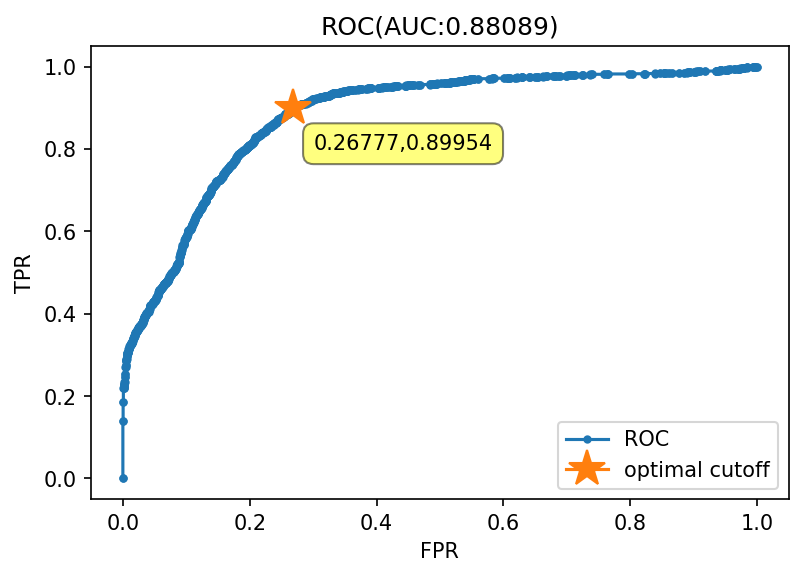

In [63]:
# 加载挑出的模型，计算 ROC 曲线、最佳阈值及 AUC 值
checkpoint_net_fe = torch.load(
    "..//ckp//opg_0217a//auc//auc880d_ep_359_2022_02_28_09_16_29.pth"
)
# net_fe = GAN_Dis_opengan_alpha(n_channel, n_d_feature)
net_fe = dnet
net_fe.to("cpu")
net_fe.load_state_dict(checkpoint_net_fe["model"])
net_fe.eval()
# 计算模型对数据集的预测值，此函数还会通过sigmod函数以保持输出在0-1内
emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set, net_vector=dnet)
# 用来计算ROC,AUC 的数据需要同格式，直接全部展平至一维
emg_vec = emg_vec.ravel()
vallabel_for_auc = vallabel_for_auc.ravel()
auc_test = metrics.roc_auc_score(vallabel_for_auc, emg_vec, average="micro")
# 计算roc曲线，以备后续绘制
fpr, tpr, thresholds = metrics.roc_curve(vallabel_for_auc, emg_vec)
auc_test_r = metrics.auc(fpr, tpr)
# 按约登指数计算最佳阈值点
optimals, points = Find_Optimal_Cutoff(tpr, fpr, thresholds)
# 作ROC图
plt.rcParams["figure.dpi"] = 150
plt.title("ROC(AUC:" + str("%.5g" % auc_test_r) + ")")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr, tpr, marker=".", label="ROC")
plt.plot(points[0], points[1], marker="*", markersize=18, label="optimal cutoff")
# 在 ROC 图上标注最佳阈值点
plt.annotate(
    str("%.5g" % points[0]) + "," + str("%.5g" % points[1]),
    xy=(points[0], points[1]),
    xytext=(10, -20),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="k", lw=1, alpha=0.5),
)
# 显示图例
plt.legend()
plt.show()

In [2]:
# 下一步应该让经过拒绝后的数据经过原始CNN分类器，再算一次准确率

# 加载完整大数据集
opg_data = np.load("../../data/OpgData_full_smr_10cl_220522_2.npy", allow_pickle=True)
opg_data = opg_data.item()
Xtrain_known = opg_data["Xtrain_known"]
Xtest_known = opg_data["Xtest_known"]
Xval_opset = opg_data["Xval_opset"]
Ytrain_known = opg_data["Ytrain_known"]
Ytest_known = opg_data["Ytest_known"]
Yval_opset = opg_data["Yval_opset"]
X_train_Net_output = opg_data["X_train_Net_output"]
X_test_Net_output = opg_data["X_test_Net_output"]
X_val_Net_output = opg_data["X_val_Net_output"]
Yval_opset_mtv = opg_data["Yval_opset_mtv"][:,0]

In [3]:
# 情形1，所有接受的样本中正确率变化
# 加载CNN，过一遍验证集，中间加入 GAN 拒绝操作
checkpoint_net_cnn = torch.load('..//ckp//opg_0217a//oth//c_ep_200_acc9763_2022_02_26_23_18_44.pth')
net_cnn = Network_CNN_6ch_6cls_smr_v1()
net_cnn.load_state_dict(checkpoint_net_cnn['model'])
net_cnn.eval()
# net_cnn.to(device)
total_testnum = 0
testdata = Xtest_known
testlabel = Ytest_known[:,0]
test_set = EMGDataset_2D(testdata, testlabel)
test_val_on_cnn_set = EMGDataset_2D(Xval_opset, Yval_opset_mtv)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=False)
test_val_on_cnn_loader = torch.utils.data.DataLoader(test_val_on_cnn_set, batch_size=2, shuffle=False)
batch1 = iter(test_loader)

In [36]:
batch2 = next(batch1)
d_x, d_y = batch2
print(
    "x:",
    d_x.shape,
    d_x,
    "\n",
    "y:",
    d_y.shape,
    d_y,
)

x: torch.Size([2, 1, 200, 6]) tensor([[[[ 0.0195,  0.0015,  0.0049, -0.0190,  0.0638,  0.0233],
          [ 0.0187, -0.0027,  0.0121,  0.0054,  0.0390,  0.0358],
          [ 0.0098,  0.0011,  0.0121,  0.0240,  0.0028,  0.0296],
          ...,
          [ 0.0160,  0.0087,  0.0680, -0.0711,  0.0055,  0.0085],
          [-0.0048,  0.0223,  0.0405, -0.0837,  0.0356,  0.0141],
          [ 0.0116,  0.0266,  0.0162, -0.1236,  0.0647,  0.0280]]],


        [[[-0.0173, -0.0149, -0.0623, -0.0209, -0.0621, -0.0923],
          [-0.0231, -0.0156, -0.0641,  0.0186, -0.0390, -0.0488],
          [-0.0206, -0.0148, -0.0535,  0.0628, -0.0144, -0.0224],
          ...,
          [-0.0247, -0.0351,  0.1067,  0.0336,  0.0373, -0.0140],
          [-0.0192, -0.0440,  0.1082,  0.0433,  0.0340, -0.0670],
          [-0.0185, -0.0384,  0.1060,  0.0619,  0.0261, -0.0861]]]],
       dtype=torch.float64) 
 y: torch.Size([2]) tensor([0, 0], dtype=torch.int16)


### 原始手势测试集，经过 CNN 后正确率

In [18]:
# 原始手势测试集，经过 CNN 后正确率
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
test_val_on_cnn_loader = torch.utils.data.DataLoader(
    test_val_on_cnn_set, batch_size=128, shuffle=False
)
# 是的，目前并没有必要使用 **不定参数，这只是一个练习，函数本身在reuse.py中
kwargs = {"device": "cuda:0", "data_set": test_loader, "network": net_cnn}
# 原始准确率
origin_acc = test_network_accuracy_xy_only(**kwargs)
kwargs = {"device": "cuda:0", "data_set": test_val_on_cnn_loader, "network": net_cnn}
# 在包含未知类的验证集上的准确率
opset_acc = test_network_accuracy_xy_only(**kwargs)
print("origin_acc:", origin_acc, "\n", "opset acc:", opset_acc)

origin_acc: 0.976313640076232 
 opset acc: 0.5765273311897106


### 被接受的数据中，准确率是否生变

In [20]:
# 被接受的数据中，准确率是否生变
# 加载判别器
path_dnet = torch.load(
    "..//ckp//opg_0217a//auc//auc880d_ep_359_2022_02_28_09_16_29.pth"
)
dnet_opset = GAN_Dis(n_channel = 6, n_d_feature = 64)
dnet_opset.to("cpu")
dnet_opset.load_state_dict(path_dnet["model"])
dnet_opset.eval()


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=6, out_features=128, bias=True)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)

In [66]:
# 计算模型对数据集的预测值，此函数还会通过sigmod函数以保持输出在0-1内
dnet_opset.to("cpu")
a_emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set, net_vector=dnet_opset)
# 用来计算ROC,AUC 的数据需要同格式，直接全部展平至一维
a_emg_vec = a_emg_vec.ravel()
a_vallabel_for_auc = vallabel_for_auc.ravel()
a_auc_test = metrics.roc_auc_score(vallabel_for_auc, emg_vec, average="micro")

In [106]:
# 加载EMG原数据，让 CNN 判断，给出的特征值过一下判别器，通过的再计数
# from collections import Counter
test_val_on_cnn_loader = torch.utils.data.DataLoader(
    test_val_on_cnn_set, batch_size=256, shuffle=False
)
optimal_cutoff = optimals
total_test_correct_kn = 0
total_testnum_kn = 0
total_test_correct_un = 0
total_testnum_un = 0
a_vec_list = []
a_vec_confidence_list = []
net_cnn.to(device)
dnet_opset.to(device)
dnet_opset.eval()
i = 0
for testemgdatas, testemglabels in test_val_on_cnn_loader:
    testemgdatas = testemgdatas.to(torch.float32)
    testemgdatas = testemgdatas.to(device)
    testemglabels = testemglabels.long()
    testemglabels = testemglabels.to(device)
    predstest = net_cnn(testemgdatas)
    # 网络输出需要过一下 sigmoid ，我查了一天，果然是因为太久没看这个项目了
    d_accept = dnet_opset(predstest).sigmoid()
    # 下面代码，甚是妙极
    aaa = d_accept >= optimal_cutoff
    # d_reject = d_reject[aaa]
    aaa_2 = aaa.squeeze()
    predstest_2 = predstest[aaa_2, :]
    preds_cpu = d_accept.to("cpu")
    a_vec_list.append((preds_cpu.detach().numpy().flatten()))
    d_reject_label = testemglabels[aaa_2]
    # 被接受的
    curr_test_correct_kn = get_num_correct(predstest, testemglabels, dim=1)
    total_testnum_kn += testemglabels.size(0)
    total_test_correct_kn += curr_test_correct_kn
    if aaa_2.sum() != 0:
        curr_test_correct_un = get_num_correct(predstest_2, d_reject_label, dim=1)
        total_testnum_un += d_reject_label.size(0)
        total_test_correct_un += curr_test_correct_un
# aaa_3 = Counter(a_vec_confidence_list)
total_test_acc_kn = total_test_correct_kn / total_testnum_kn
total_test_acc_un = total_test_correct_un / total_testnum_un
print(
    "ACC before rejection:",
    total_test_acc_kn, 
    "AER:",1-total_test_acc_kn,
    "\n",
    "ACC after rejection:",
    total_test_acc_un,
    "AER:",1-total_test_acc_un
)

ACC before rejection: 0.5765273311897106 AER: 0.42347266881028944 
 ACC after rejection: 0.8107904642409034 AER: 0.1892095357590966
